<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/58/Uber_logo_2018.svg/1024px-Uber_logo_2018.svg.png" alt="UBER LOGO" width="50%" />

# UBER Pickups

## Company's Description 📇

<a href="http://uber.com/" target="_blank">Uber</a> is one of the most famous startup in the world. It started as a ride-sharing application for people who couldn't afford a taxi. Now, Uber expanded its activities to Food Delivery with <a href="https://www.ubereats.com/fr-en" target="_blank">Uber Eats</a>, package delivery, freight transportation and even urban transportation with <a href="https://www.uber.com/fr/en/ride/uber-bike/" target="_blank"> Jump Bike</a> and <a href="https://www.li.me/" target="_blank"> Lime </a> that the company funded.


The company's goal is to revolutionize transportation accross the globe. It operates now on about 70 countries and 900 cities and generates over $14 billion revenue! 😮


## Project 🚧

One of the main pain point that Uber's team found is that sometimes drivers are not around when users need them. For example, a user might be in San Francisco's Financial District whereas Uber drivers are looking for customers in Castro.  

(If you are not familiar with the bay area, check out <a href="https://www.google.com/maps/place/San+Francisco,+CA,+USA/@37.7515389,-122.4567213,13.43z/data=!4m5!3m4!1s0x80859a6d00690021:0x4a501367f076adff!8m2!3d37.7749295!4d-122.4194155" target="_blank">Google Maps</a>)

Eventhough both neighborhood are not that far away, users would still have to wait 10 to 15 minutes before being picked-up, which is too long. Uber's research shows that users accept to wait 5-7 minutes, otherwise they would cancel their ride.

Therefore, Uber's data team would like to work on a project where **their app would recommend hot-zones in major cities to be in at any given time of day.**  

## Goals 🎯

Uber already has data about pickups in major cities. Your objective is to create algorithms that will determine where are the hot-zones that drivers should be in. Therefore you will:

* Create an algorithm to find hot zones
* Visualize results on a nice dashboard

## Scope of this project 🖼️

To start off, Uber wants to try this feature in New York city. Therefore you will only focus on this city. Data can be found here:

👉👉<a href="https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Machine+Learning+non+Supervis%C3%A9/Projects/uber-trip-data.zip" target="_blank"> Uber Trip Data</a> 👈👈

**You only need to focus on New York City for this project**

In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd

import zipfile
import os
import glob

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Extract all csv files

In [3]:
filepath = '/content/drive/MyDrive/_JEDHA_DATASCIENCE/UNSUPERVISED_ML/project_uber/uber-trip-data'

In [4]:
# Save file with filepath
csv_files = glob.glob(f"{filepath}/*14.csv")

In [5]:
# Merge  Uber raw data files
dfs = [pd.read_csv(file) for file in csv_files]

# Concatenate all DataFrames into one
merged_df = pd.concat(dfs, ignore_index=True)

print(f"Total rows: {merged_df.shape[0]}, Total columns: {merged_df.shape[1]}")

Total rows: 4534327, Total columns: 4


In [10]:
# Save file into csv
merged_df.to_csv(f'{filepath}merged_df.csv')

##1. Overview and Understanding the datasets

1.1 Dataset 1

In [39]:
# Uber raw data 2014
trip_data = pd.read_csv(f'{filepath}merged_df.csv').drop('Unnamed: 0', axis=True)
print(f'Data types:\n', trip_data.dtypes)
print(f'\n',trip_data.head())

# Dataset size
print(f"Total rows: {trip_data.shape[0]}, Total columns: {trip_data.shape[1]}")

#Basic stats
print(f'\nBasic stats: \n', trip_data.describe(include='all'))

# Check missing values
print(f'\nMissing values:\n',trip_data.isnull().mean() * 100)

# Count duplicates based on key trip features
print(f'\nTotal duplicates:',trip_data.duplicated(subset=['Date/Time', 'Lat', 'Lon', 'Base']).sum())

Data types:
 Date/Time     object
Lat          float64
Lon          float64
Base          object
dtype: object

           Date/Time      Lat      Lon    Base
0  8/1/2014 0:03:00  40.7366 -73.9906  B02512
1  8/1/2014 0:09:00  40.7260 -73.9918  B02512
2  8/1/2014 0:12:00  40.7209 -74.0507  B02512
3  8/1/2014 0:12:00  40.7387 -73.9856  B02512
4  8/1/2014 0:12:00  40.7323 -74.0077  B02512
Total rows: 4534327, Total columns: 4

Basic stats: 
                 Date/Time           Lat           Lon     Base
count             4534327  4.534327e+06  4.534327e+06  4534327
unique             260093           NaN           NaN        5
top     4/7/2014 20:21:00           NaN           NaN   B02617
freq                   97           NaN           NaN  1458853
mean                  NaN  4.073926e+01 -7.397302e+01      NaN
std                   NaN  3.994991e-02  5.726670e-02      NaN
min                   NaN  3.965690e+01 -7.492900e+01      NaN
25%                   NaN  4.072110e+01 -7.399650e+01

In [40]:
trip_data.head()

,Date/Time,Lat,Lon,Base
0,8/1/2014 0:03:00,40.7366,-73.9906,B02512
1,8/1/2014 0:09:00,40.7260,-73.9918,B02512
2,8/1/2014 0:12:00,40.7209,-74.0507,B02512
3,8/1/2014 0:12:00,40.7387,-73.9856,B02512
4,8/1/2014 0:12:00,40.7323,-74.0077,B02512


The 'Date/Time' is stored as objet. Let's convert this to 'datetime'.

In [41]:
trip_data['Date/Time'] = pd.to_datetime(trip_data['Date/Time'])

1.2 Dataset 2

In [42]:
# Load dataset
dispatch_data = pd.read_csv(f'{filepath}/uber-raw-data-janjune-15.csv')

# Uber raw data from january to june 2015
print(f'Data types:\n', dispatch_data.dtypes)
print(dispatch_data.head())

#Basic stats
print(f'\nBasic stats: \n', dispatch_data.describe(include='all'))

# Check missing values
print(f'Missing values:\n',dispatch_data.isnull().mean() * 100)

# Count duplicates
print(f'\nTotal duplicates:',dispatch_data.duplicated().sum())

Data types:
 Dispatching_base_num    object
Pickup_date             object
Affiliated_base_num     object
locationID               int64
dtype: object
  Dispatching_base_num          Pickup_date Affiliated_base_num  locationID
0               B02617  2015-05-17 09:47:00              B02617         141
1               B02617  2015-05-17 09:47:00              B02617          65
2               B02617  2015-05-17 09:47:00              B02617         100
3               B02617  2015-05-17 09:47:00              B02774          80
4               B02617  2015-05-17 09:47:00              B02617          90

Basic stats: 
        Dispatching_base_num          Pickup_date Affiliated_base_num  \
count               1048575              1048575             1036592   
unique                    4               336354                 254   
top                  B02764  2015-06-17 19:26:00              B02764   
freq                 521996                  112              379229   
mean             

The 'Pickup Date' is stored as objet. Let's convert this to 'datetime'.

In [43]:
dispatch_data['Pickup_date'] = pd.to_datetime(dispatch_data['Pickup_date'])

In [44]:
dispatch_data.rename(columns={'locationID':'LocationID'}, inplace=True)

1.3 Dataset 3

In [45]:
# Load 3rd dataset
nyc_data = pd.read_csv(f'{filepath}/taxi-zone-lookup.csv')

print(f'Data types:\n', nyc_data.dtypes)
print(nyc_data.head())

#Basic stats
print(f'\nBasic stats: \n', nyc_data.describe(include='all'))

# Check missing values
print(f'Missing values:\n',nyc_data.isnull().mean() * 100)

# Count duplicates
print(f'\nTotal duplicates:',nyc_data.duplicated().sum())

print(nyc_data.groupby('Borough').sum())

Data types:
 LocationID     int64
Borough       object
Zone          object
dtype: object
   LocationID        Borough                     Zone
0           1            EWR           Newark Airport
1           2         Queens              Jamaica Bay
2           3          Bronx  Allerton/Pelham Gardens
3           4      Manhattan            Alphabet City
4           5  Staten Island            Arden Heights

Basic stats: 
         LocationID Borough                                           Zone
count   265.000000     265                                            265
unique         NaN       7                                            261
top            NaN  Queens  Governor's Island/Ellis Island/Liberty Island
freq           NaN      69                                              3
mean    133.000000     NaN                                            NaN
std      76.643112     NaN                                            NaN
min       1.000000     NaN                          

##Dataset Summary:

**1. Trip data :** The first dataset provides raw trip data with exact locations. Each invidual trip records  with GPs coordinates (lat, lon).  We will call this dataset 'trip_data'.
  - Duplicates: We will not remove duplicates at this time because they're might be a high demand on specific areas and drivers may have the same pickups at the same GPS location repeatedly.
  - Date/Time: The 'Date/Time' was stored as object. The column has been converted to correct datatype.



**2. Dispatch data:** The second dataset links dispatches to a locationID (but lacks exact GPS coordinates). This will be called 'disptach_data'.
  - Duplicates: We will also keep the duplicates as multiple drivers could be dispatched for the same request before one accepts. High-demande areas may have multiple dispatches to the same location. And if a request is reassigned due to a driver canceling, it may appear multiple times with different timestamps.
  - Missing values: We have missing values on 'Affiliated_base_num' and this can be normal because some drivers may not be affiliated with a base. This will be filled with 'Unknown'.
  - Pickup_date: It was stored as object. The column has been converted to correct datatype.

**3. Location zones:** This dataset has mapping of locationID to NYC boroughs and zones. This will be our 'nyc_data'.


##2. Data Preprocessing

2.1 Feature Engineering on Date

In [46]:
# Extract Time Features of trip_data and dispatch_data
trip_data['hour'] = trip_data['Date/Time'].dt.hour
trip_data['day'] = trip_data['Date/Time'].dt.day
trip_data['weekday'] = trip_data['Date/Time'].dt.day_name()
trip_data['month'] = trip_data['Date/Time'].dt.month

In [47]:
print(trip_data.head())
print(dispatch_data.head())

            Date/Time      Lat      Lon    Base  hour  day weekday  month
0 2014-08-01 00:03:00  40.7366 -73.9906  B02512     0    1  Friday      8
1 2014-08-01 00:09:00  40.7260 -73.9918  B02512     0    1  Friday      8
2 2014-08-01 00:12:00  40.7209 -74.0507  B02512     0    1  Friday      8
3 2014-08-01 00:12:00  40.7387 -73.9856  B02512     0    1  Friday      8
4 2014-08-01 00:12:00  40.7323 -74.0077  B02512     0    1  Friday      8
  Dispatching_base_num         Pickup_date Affiliated_base_num  LocationID
0               B02617 2015-05-17 09:47:00              B02617         141
1               B02617 2015-05-17 09:47:00              B02617          65
2               B02617 2015-05-17 09:47:00              B02617         100
3               B02617 2015-05-17 09:47:00              B02774          80
4               B02617 2015-05-17 09:47:00              B02617          90


**Merge Datasets**

In [48]:
# Standardize LocationID types
dispatch_data['LocationID'] = dispatch_data['LocationID'].astype(int)
nyc_data['LocationID'] = nyc_data['LocationID'].astype(int)

# Get the list of valid NYC LocationIDs
nyc_location_ids = nyc_data['LocationID'].unique()

# Filter dispatch_data where LocationID is in NYC list
dispatch_data_nyc = dispatch_data[dispatch_data['LocationID'].isin(nyc_location_ids)]

# Merge Borough and Zone into dispatch_data_nyc
dispatch_data_nyc = dispatch_data_nyc.merge(
    nyc_data[['LocationID', 'Borough', 'Zone']],
    on='LocationID',
    how='left'
)


In [49]:
dispatch_data_nyc.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,LocationID,Borough,Zone
0,B02617,2015-05-17 09:47:00,B02617,141,Manhattan,Lenox Hill West
1,B02617,2015-05-17 09:47:00,B02617,65,Brooklyn,Downtown Brooklyn/MetroTech
2,B02617,2015-05-17 09:47:00,B02617,100,Manhattan,Garment District
3,B02617,2015-05-17 09:47:00,B02774,80,Brooklyn,East Williamsburg
4,B02617,2015-05-17 09:47:00,B02617,90,Manhattan,Flatiron


In [50]:
dispatch_data_nyc.drop(['Pickup_date'],axis=1)

,Dispatching_base_num,Affiliated_base_num,LocationID,Borough,Zone
0,B02617,B02617,141,Manhattan,Lenox Hill West
1,B02617,B02617,65,Brooklyn,Downtown Brooklyn/MetroTech
2,B02617,B02617,100,Manhattan,Garment District
3,B02617,B02774,80,Brooklyn,East Williamsburg
4,B02617,B02617,90,Manhattan,Flatiron
...,...,...,...,...,...
1048570,B02764,B02682,52,Brooklyn,Cobble Hill
1048571,B02764,B02764,230,Manhattan,Times Sq/Theatre District
1048572,B02764,B02788,246,Manhattan,West Chelsea/Hudson Yards
1048573,B02764,B02764,107,Manhattan,Gramercy


In [51]:
# Create lookup dictionary {Base: LocationID} only for NYC
dispatch_lookup = dispatch_data_nyc.set_index('Affiliated_base_num')['LocationID'].to_dict()

# Map LocationID to trip_data based on Base
trip_data['LocationID'] = trip_data['Base'].map(dispatch_lookup)

In [52]:
# Merge geographic info into trip_data
trip_data = trip_data.merge(
    nyc_data[['LocationID', 'Borough', 'Zone']],
    on='LocationID',
    how='left'
)

In [53]:
trip_data.head()

,Date/Time,Lat,Lon,Base,hour,day,weekday,month,LocationID,Borough,Zone
0,2014-08-01 00:03:00,40.7366,-73.9906,B02512,0,1,Friday,8,192,Queens,Queensboro Hill
1,2014-08-01 00:09:00,40.7260,-73.9918,B02512,0,1,Friday,8,192,Queens,Queensboro Hill
2,2014-08-01 00:12:00,40.7209,-74.0507,B02512,0,1,Friday,8,192,Queens,Queensboro Hill
3,2014-08-01 00:12:00,40.7387,-73.9856,B02512,0,1,Friday,8,192,Queens,Queensboro Hill
4,2014-08-01 00:12:00,40.7323,-74.0077,B02512,0,1,Friday,8,192,Queens,Queensboro Hill


2.3 Drop duplicate columns and filter out missing Values

In [54]:
trip_data_cleaned = trip_data.drop(columns='Date/Time')

In [55]:
trip_data_cleaned.head()

,Lat,Lon,Base,hour,day,weekday,month,LocationID,Borough,Zone
0,40.7366,-73.9906,B02512,0,1,Friday,8,192,Queens,Queensboro Hill
1,40.7260,-73.9918,B02512,0,1,Friday,8,192,Queens,Queensboro Hill
2,40.7209,-74.0507,B02512,0,1,Friday,8,192,Queens,Queensboro Hill
3,40.7387,-73.9856,B02512,0,1,Friday,8,192,Queens,Queensboro Hill
4,40.7323,-74.0077,B02512,0,1,Friday,8,192,Queens,Queensboro Hill


In [56]:
# Let's filter out missing values
trip_data_cleaned = trip_data_cleaned[
    trip_data_cleaned['LocationID'].notna() &
    trip_data_cleaned['Borough'].notna() &
    trip_data_cleaned['Zone'].notna()
]
trip_data_cleaned['LocationID'] = trip_data_cleaned['LocationID'].astype(int)

# 3. Compare K-Means & DBSCAN algorithms for Clustering

###3.1 To start , let's pick one day at a given hour and check the hot-zones.

In [60]:
# Filter 'Monday' at '17'
df_hotzone = trip_data_cleaned[(trip_data_cleaned['weekday']=='Monday') & (trip_data_cleaned['hour'] ==17)]

In [61]:
print(df_hotzone.head())
print(df_hotzone.size)

          Lat      Lon    Base  hour  day weekday  month  LocationID Borough  \
4021  40.7585 -74.0002  B02512    17    4  Monday      8         192  Queens   
4022  40.7585 -74.0002  B02512    17    4  Monday      8         192  Queens   
4023  40.7674 -73.9538  B02512    17    4  Monday      8         192  Queens   
4024  40.7576 -74.0009  B02512    17    4  Monday      8         192  Queens   
4025  40.6697 -73.9504  B02512    17    4  Monday      8         192  Queens   

                 Zone  
4021  Queensboro Hill  
4022  Queensboro Hill  
4023  Queensboro Hill  
4024  Queensboro Hill  
4025  Queensboro Hill  
420230


In [62]:
# Visualization of hot-zones
fig = px.scatter_mapbox(df_hotzone,
                     lat='Lat',
                     lon ='Lon',
                     mapbox_style='open-street-map',
                     color ='weekday',
                     zoom = 10,
                     center = {'lat': 40.7128, 'lon': -74.0060},
                     )

fig.update_layout(
      title_text="Hotzones in New York on a Monday at 5pm",
      title_x=0.5,
      width =1100,
      height =700
      )

fig.show()

##3.2 Apply K-Means Clustering

In [63]:
from sklearn.cluster import KMeans
scaler = StandardScaler()

X = df_hotzone[['Lat', 'Lon']]

X = scaler.fit_transform(X)

**Let's use the Elbow method to find the best k**

In [64]:
wcss = []
k_range = range(1,11)

for k in k_range :
  kmeans = KMeans(n_clusters =k,random_state=42)
  kmeans.fit(X)
  wcss.append(kmeans.inertia_)
  print(f"WCSS for K={k} --> {wcss[-1]}")

WCSS for K=1 --> 84046.0000000001
WCSS for K=2 --> 56985.35512880866
WCSS for K=3 --> 38816.38046133046
WCSS for K=4 --> 30398.33282775649
WCSS for K=5 --> 26642.071801288123
WCSS for K=6 --> 20707.85089640209
WCSS for K=7 --> 18570.23507996089
WCSS for K=8 --> 14827.51301696309
WCSS for K=9 --> 12854.797587839139
WCSS for K=10 --> 11766.007339323873


**Visualize the elbow method results**

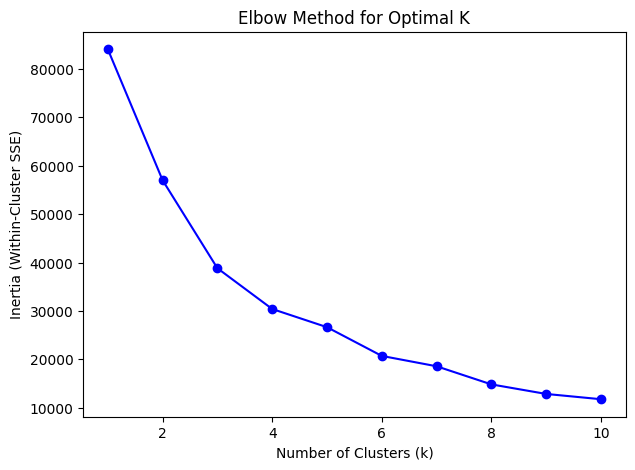

In [65]:
# Plot Elbow Method
plt.figure(figsize=(7,5))
plt.plot(k_range, wcss,'bo-', markersize=6)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-Cluster SSE)")
plt.title("Elbow Method for Optimal K")
plt.show()

Based on the results, the “elbow” point, where the rate of decrease in inertia slows down, is observed at k = 3.

**Let's apply K-means to our X**

In [66]:
kmeans = KMeans(n_clusters=3, random_state=42)
df_hotzone['kmeans_cluster'] = kmeans.fit_predict(X)

print(df_hotzone.loc[:,'kmeans_cluster'].value_counts())

kmeans_cluster
0    24962
2    15730
1     1331
Name: count, dtype: int64


<ipython-input-66-65e30425703c>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [67]:
print(kmeans.cluster_centers_)

[[ 0.57260287  0.06792768]
 [-2.21578295  3.82042365]
 [-0.71536301 -0.42881918]]


In [87]:
# Visualization of K-means Cluster Centers
centroids = kmeans.cluster_centers_

# create scatter plot
fig_kmeans = px.scatter_map(df_hotzone,
                        lat='Lat',
                        lon ='Lon',
                        color ='kmeans_cluster',
                        center={"lat": 40.7128, "lon": -74.0060},
                        title="Kmeans Clusters - Hotzones in New York at 5 p.m. on Monday",
                        zoom =8,
                        )

fig_kmeans.update_layout(
    title_x=0.5,
    height=600,
    width=1000)
fig_kmeans.show()

Even after applying K-Means, there are points that are too far from their assigned centroid. This is as expected when using K-means. These points are our outliers. Low-density areas get clustered incorrectly.

##3.3 Apply DBSCAN Clustering

In [75]:
from sklearn.cluster import DBSCAN
# Apply DBSCAN
dbscan = DBSCAN(eps=0.15, metric='manhattan', min_samples=100, n_jobs=-1)

df_hotzone['dbscan_cluster'] = dbscan.fit_predict(X)
print(df_hotzone['dbscan_cluster'].value_counts())

dbscan_cluster
 0    34178
-1     4085
 1      931
 4      860
 2      826
 5      727
 3      295
 6      121
Name: count, dtype: int64


<ipython-input-75-05888978e8cd>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [81]:
df_hotzone['Zone'].unique()

,Lat,Lon,Base,hour,day,weekday,month,LocationID,Borough,Zone,kmeans_cluster,dbscan_cluster
4021,40.7585,-74.0002,B02512,17,4,Monday,8,192,Queens,Queensboro Hill,0,0
4022,40.7585,-74.0002,B02512,17,4,Monday,8,192,Queens,Queensboro Hill,0,0
4023,40.7674,-73.9538,B02512,17,4,Monday,8,192,Queens,Queensboro Hill,0,0
4024,40.7576,-74.0009,B02512,17,4,Monday,8,192,Queens,Queensboro Hill,0,0
4025,40.6697,-73.9504,B02512,17,4,Monday,8,192,Queens,Queensboro Hill,2,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
4532719,40.6610,-73.9608,B02764,17,26,Monday,5,100,Manhattan,Garment District,2,-1
4532720,40.6451,-73.7809,B02764,17,26,Monday,5,100,Manhattan,Garment District,1,1
4532721,40.7409,-73.9881,B02764,17,26,Monday,5,100,Manhattan,Garment District,0,0
4532722,40.7502,-73.8955,B02764,17,26,Monday,5,100,Manhattan,Garment District,0,-1


In [88]:
# Visualization of DBSCAN
fig_dbscan = px.scatter_map(
    df_hotzone[df_hotzone['dbscan_cluster'] !=-1],
    lat ='Lat',
    lon ='Lon',
    color ='dbscan_cluster',
    map_style='open-street-map',
    center={'lat': 40.7128, 'lon': -74.0060},
    title='DBSCAN Clusters - Hotzones in New York at 5 p.m. on Monday',
    zoom =10
    )

fig_dbscan.update_layout(
    title_x=0.5,
    height=600,
    width=1000)
fig_dbscan.show()

Our DBSCAN model has correctly identified Uber pickup hotzones on a friday at 5pm at the following locations:

- Cluster 0 : Manhattan : Midtown Manhattan
- Cluster 1 : Queens : JFK Airport
- Cluster 2 : Queens : LaGuardia Airport
- Cluster 3 : New Jersey (Outside NYC) : Newark Liberty Airport
- Cluster 4 : Brooklyn : Williamsburg
- Cluster 5 : Brooklyn : Downtown Brooklyn
- Cluster 6 : Queens : Long Island City

These are known high-demand Uber pickup areas and the model has correctly separated key locations such as major transport hubs and NYC business districts.